In [108]:
import torch
import torch.backends.cudnn as cudnn
device = torch.cuda.set_device('cuda:1')
import matplotlib.pyplot as plt
from skimage.io import imread 
from skimage.transform import resize
import numpy as np
from utils import *
from skimage.io import imread
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose

In [109]:
import archs

In [110]:
model = archs.NestedUNet(1, 3, False)

In [111]:
model = model.cuda()

In [112]:
#Load save model
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [113]:
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    

In [114]:
network_size = (256,256,3)

In [115]:
overlap = 0

In [127]:
image = np.asarray(imread('WPTest.PNG'), dtype=np.float32)
image = image[:,:,(0,1,2)]
for chan in range(0,image.shape[2]):
    mean_ch = image[:,:,chan].mean()
    std_ch = image[:,:,chan].std()
    image[:,:,chan] = (image[:,:,chan] - mean_ch) / (std_ch+1e-12)
img = image

In [144]:
img.mean()

4.1785944e-07

In [128]:
image_size = list(image.shape[0:2]) #Get image size and push to a list
tile_size = list(network_size[0:2]) #Get tile size as first two dimensions of network_size
        
corners = find_corners(image_size, tile_size, network_size, overlap)

tilesArr = create_tiles(img, corners, network_size)
tilesArr = tilesArr.astype('float32')
tilesArr = tilesArr.transpose(0, 3, 1, 2)
tilesArr = torch.from_numpy(tilesArr)
tilesArr = tilesArr.cuda()

In [129]:
with torch.no_grad():
    output = model(tilesArr)
    #output = model(img)
    output = torch.sigmoid(output).cpu().numpy()

In [130]:
torch.cuda.empty_cache()

In [131]:
def assemble_pred(predArr, corners, image, network_size):
    pred_image = np.zeros((image.shape[0], image.shape[1]))
    pred_image[:,:] = np.nan #NaN so we only average the overlap
    corn_idx = 0
    for pred in predArr:
        cornerSet = corners[corn_idx]
        topY = cornerSet[0,0]
        topX = cornerSet[0,1]
        botY = cornerSet[1,0]
        botX = cornerSet[1,1]
        tile_shape = cornerSet[2]

        img_tile = pred_image[topY:botY, topX:botX] #Tile from our total prediction image
        
        flat_img_tile = np.ndarray.flatten(img_tile) 

        pred = pred[0, 0:tile_shape[0], 0:tile_shape[1]]
        
        flat_pred_tile = np.ndarray.flatten(pred)
    
        new_img_tile = list(map(lambda x, y: y if np.isnan(x) else (x+y)/2, flat_img_tile, flat_pred_tile)) #Average the predictions if x isn't NaN

        new_img_tile = np.asarray(new_img_tile).reshape(tile_shape)
        
        pred_image[topY:botY, topX:botX] = pred#new_img_tile
            
        corn_idx += 1  
    return pred_image      

In [133]:
final = assemble_pred(output, corners, image, network_size)

In [150]:
final2 = np.array(final*255, dtype="uint16")

In [151]:
import cv2
ret2,th2 = cv2.threshold(final2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

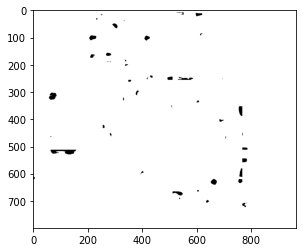

In [154]:
plt.imshow(th2, cmap = 'gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


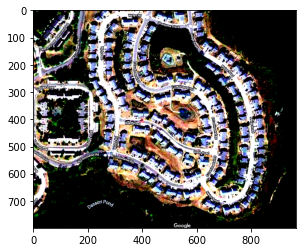

In [135]:
plt.imshow(img)